In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ta

In [2]:
dataset_train = pd.read_csv('train.csv')
dataset_train = dataset_train.drop(["Date","Turnover (Lacs)"], axis=1)
RSI=ta.momentum.rsi(close=dataset_train['Close'])
MFI=ta.volume.money_flow_index(dataset_train['High'], dataset_train['Low'], dataset_train['Close'], dataset_train['Total Trade Quantity'],n=14)
dataset_train["RSI"]= RSI
dataset_train["MFI"]=MFI
values={'RSI':RSI.mean(),'MFI': MFI.mean()}
dataset_train=dataset_train.fillna(value=values)
print(dataset_train)

       Open    High     Low    Last   Close  Total Trade Quantity        RSI  \
0     88.00   88.00   70.00   75.55   75.55             232535736  55.473297   
1     76.80   78.60   75.00   75.15   75.20              68865277  55.473297   
2     75.10   76.10   74.55   75.25   75.30              37460886  55.473297   
3     75.50   75.95   75.00   75.05   75.05              17413433  55.473297   
4     75.35   75.40   74.30   74.60   74.45              15961426  55.473297   
..      ...     ...     ...     ...     ...                   ...        ...   
795  266.25  279.40  262.10  276.00  277.15              16240067  67.412752   
796  277.00  283.45  263.45  266.15  265.85              16313197  58.527540   
797  267.10  274.45  262.10  274.45  272.25              10923531  61.613501   
798  275.00  287.90  270.00  286.85  284.65              12711465  66.772390   
799  289.00  290.75  271.00  271.80  274.00              18865911  59.389900   

           MFI  
0    57.374425  
1    

In [3]:
training_set = dataset_train.iloc[:,:].values

In [4]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [5]:
X_train = []
y_train = []
for i in range(60, 800):
    X_train.append(training_set_scaled[i-60:i])
    y_train.append(training_set_scaled[i,4])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 8))

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.
C:\Users\HI\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\HI\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\HI\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\HI\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: Future

In [7]:
regressor = Sequential()

regressor.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 8)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 60))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 1, batch_size = 60)


Epoch 1/1
740/740 [==============================] - 2s 3ms/step - loss: 0.0287


In [8]:
dataset_test = pd.read_csv('test.csv')
real_stock_price = dataset_test.iloc[:, 5:6].values
print(len(real_stock_price))
dataset_test = dataset_test.drop(["Date","Turnover (Lacs)"], axis=1)
RSI=ta.momentum.rsi(close=dataset_test['Close'])
MFI=ta.volume.money_flow_index(dataset_test['High'], dataset_test['Low'], dataset_test['Close'], dataset_test['Total Trade Quantity'],n=14)
dataset_test["RSI"]= RSI
dataset_test["MFI"]=MFI
values1={'RSI':RSI.mean(),'MFI': MFI.mean()}
dataset_test=dataset_test.fillna(value=values1)

300


In [9]:
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total)-len(dataset_test)-60:].values
inputs = inputs.reshape(-1,8)
inputs = sc.transform(inputs)

In [21]:
X_test = []
print(len(inputs))
for i in range(60, 361) :
    X_test.append(inputs[i-60:i])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],8))
predicted_stock_price = regressor.predict(X_test)
print(len(predicted_stock_price))
print(len(X_test))

360


IndexError: tuple index out of range

In [11]:
predicted_stock_price1 = np.zeros(shape=(len(X_test), 8) )
predicted_stock_price1[:,4] = predicted_stock_price[:,0]
predicted_stock_price2 = sc.inverse_transform(predicted_stock_price1)[:,4]

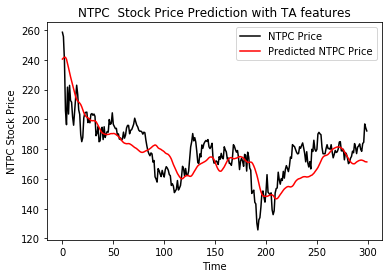

In [12]:
plt.plot(real_stock_price, color = 'black', label = 'NTPC Price')
plt.plot(predicted_stock_price2, color = 'red', label = 'Predicted NTPC Price')
plt.title('NTPC  Stock Price Prediction with TA features')
plt.xlabel('Time')
plt.ylabel('NTPC Stock Price')
plt.legend()
plt.show()

In [13]:
estimation_residue=(real_stock_price-predicted_stock_price2)
estimation_residue.mean()

2.45533018175763

In [14]:
estimation_percentage=(real_stock_price/predicted_stock_price2)
estimation_percentage.mean()

1.024013546149626